In [144]:
import pickle
import pandas as pd
import numpy as np

In [145]:
df = pd.read_pickle('turbine1_df_final.pkl')



In [146]:
df['# Date and time'] = pd.to_datetime(df['# Date and time'])
# Perform cyclic encoding for month and hour
df['month_sin'] = np.sin(2 * np.pi * df['# Date and time'].dt.month / 12)
df['month_cos'] = np.cos(2 * np.pi * df['# Date and time'].dt.month / 12)

df['hour_sin'] = np.sin(2 * np.pi * df['# Date and time'].dt.hour / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['# Date and time'].dt.hour / 24)

# Drop the original 'Date and time' column
df.drop('# Date and time', axis=1, inplace=True)

In [147]:
from sklearn.model_selection import train_test_split

# Split the dataset into training, validation, and testing sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, shuffle=False)
train_df, val_df = train_test_split(train_df, test_size=0.25, random_state=42, shuffle=False)

# Print the shape of each split
print('Training set shape:', train_df.shape)
print('Validation set shape:', val_df.shape)
print('Testing set shape:', test_df.shape)
test_df.reset_index(drop=True, inplace=True)
val_df.reset_index(drop=True, inplace=True)

Training set shape: (78436, 66)
Validation set shape: (26146, 66)
Testing set shape: (26146, 66)


In [148]:
from pytorch_tabnet.tab_model import TabNetRegressor

import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

import pandas as pd
import numpy as np
np.random.seed(0)


import os


In [149]:
train_indices = train_df.index
valid_indices = val_df.index
test_indices = test_df.index
print(valid_indices)

RangeIndex(start=0, stop=26146, step=1)


In [150]:
target = 'Power (kW)'
features = [ col for col in train_df.columns if col not in target] 

X_train = train_df[features].values[train_indices]
y_train = train_df[target].values[train_indices].reshape(-1, 1)

X_valid = val_df[features].values[valid_indices]
y_valid = val_df[target].values[valid_indices].reshape(-1, 1)

X_test = test_df[features].values[test_indices]
y_test = test_df[target].values[test_indices].reshape(-1, 1)


In [151]:
max_epochs = 78 if not os.getenv("CI", False) else 2

In [152]:
from pytorch_tabnet.augmentations import RegressionSMOTE
aug = RegressionSMOTE(p=0.2)


In [153]:

clf = TabNetRegressor(n_d=8, n_a=8, n_steps=8 ,gamma=1.95)


/home/krishna/miniconda3/envs/dl/lib/python3.11/site-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


In [154]:
clf.fit(
    X_train=X_train, y_train=y_train,
    eval_set=[(X_train, y_train), (X_valid, y_valid)],
    eval_name=['train', 'valid'],
    eval_metric=['rmsle', 'mae', 'rmse', 'mse'],
    max_epochs=max_epochs,
    patience=50,
    batch_size=1024, virtual_batch_size=128,
    num_workers=0,
    drop_last=False,
    augmentations=aug, #aug
) 

epoch 0  | loss: 1.20478 | train_rmsle: 0.03036 | train_mae: 0.18386 | train_rmse: 0.26408 | train_mse: 0.06974 | valid_rmsle: 0.02432 | valid_mae: 0.15791 | valid_rmse: 0.23569 | valid_mse: 0.05555 |  0:00:09s
epoch 1  | loss: 0.08554 | train_rmsle: 0.02308 | train_mae: 0.17494 | train_rmse: 0.23031 | train_mse: 0.05304 | valid_rmsle: 0.02167 | valid_mae: 0.16731 | valid_rmse: 0.21721 | valid_mse: 0.04718 |  0:00:18s
epoch 2  | loss: 0.01136 | train_rmsle: 0.01211 | train_mae: 0.12443 | train_rmse: 0.17439 | train_mse: 0.03041 | valid_rmsle: 0.01142 | valid_mae: 0.11899 | valid_rmse: 0.16261 | valid_mse: 0.02644 |  0:00:27s
epoch 3  | loss: 0.00802 | train_rmsle: 0.00794 | train_mae: 0.10421 | train_rmse: 0.1367  | train_mse: 0.01869 | valid_rmsle: 0.0067  | valid_mae: 0.09422 | valid_rmse: 0.11982 | valid_mse: 0.01436 |  0:00:36s
epoch 4  | loss: 0.00506 | train_rmsle: 0.00424 | train_mae: 0.07189 | train_rmse: 0.10037 | train_mse: 0.01007 | valid_rmsle: 0.00377 | valid_mae: 0.06658 

/home/krishna/miniconda3/envs/dl/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [155]:
preds = clf.predict(X_test)

y_true = y_test

test_score = mean_squared_error(y_pred=preds, y_true=y_true)


In [156]:
print(test_score)

0.001514971264552074


In [157]:
clf.feature_importances_

array([6.11538277e-01, 5.61873123e-04, 0.00000000e+00, 2.30704271e-06,
       3.65581559e-02, 1.51229659e-03, 1.59573464e-02, 6.03671300e-09,
       9.48644367e-03, 4.06848345e-03, 1.95566726e-06, 0.00000000e+00,
       3.92683522e-05, 1.18312802e-03, 0.00000000e+00, 0.00000000e+00,
       9.04124124e-04, 6.91296694e-05, 2.57246995e-03, 3.79340176e-07,
       0.00000000e+00, 2.66246792e-02, 1.33457175e-02, 6.78236030e-06,
       2.85064048e-02, 7.52098159e-02, 1.57747589e-06, 1.35335202e-03,
       3.63407463e-05, 0.00000000e+00, 6.57914394e-04, 1.02729179e-05,
       0.00000000e+00, 0.00000000e+00, 6.83213783e-05, 1.80172395e-03,
       0.00000000e+00, 0.00000000e+00, 1.88470624e-04, 2.77432353e-05,
       4.42888905e-02, 0.00000000e+00, 4.79084817e-02, 1.02780849e-04,
       9.07929600e-07, 8.18123042e-04, 0.00000000e+00, 2.34352022e-02,
       1.07498522e-03, 1.71025742e-02, 1.40700601e-02, 0.00000000e+00,
       3.65063998e-06, 0.00000000e+00, 2.61146865e-05, 0.00000000e+00,
      

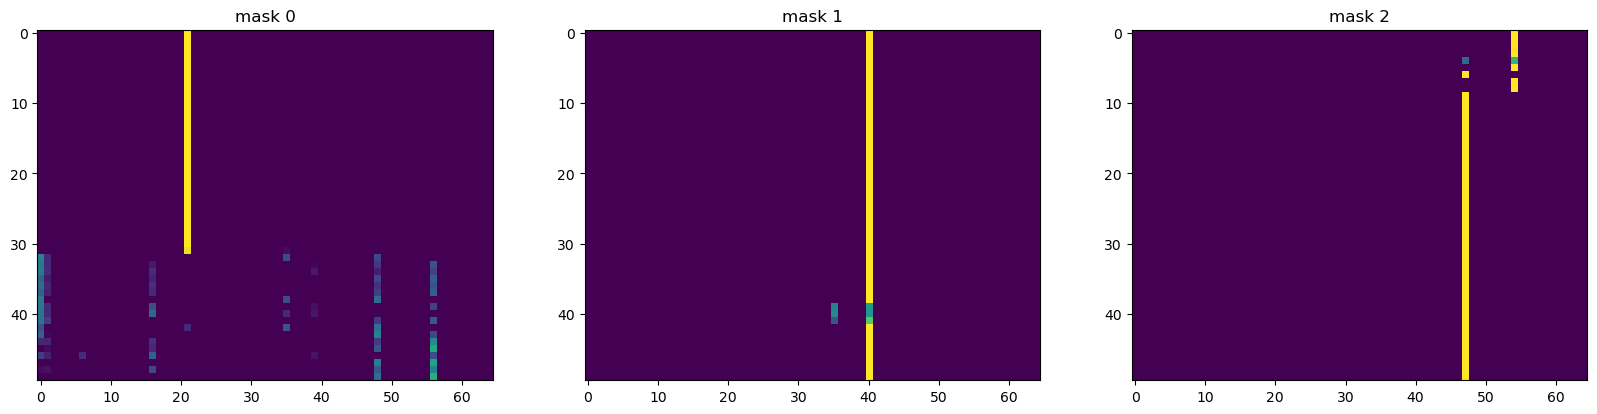

In [158]:
explain_matrix, masks = clf.explain(X_test)
from matplotlib import pyplot as plt
fig, axs = plt.subplots(1, 3, figsize=(20,20))

for i in range(3):
    axs[i].imshow(masks[i][:50])
    axs[i].set_title(f"mask {i}")

In [159]:
from xgboost import XGBRegressor

clf_xgb = XGBRegressor(max_depth=8,
    learning_rate=0.1,
    n_estimators=1000,
    verbosity=0,
    silent=None,
    objective='reg:linear',
    booster='gbtree',
    n_jobs=-1,
    nthread=None,
    gamma=0,
    min_child_weight=1,
    max_delta_step=0,
    subsample=0.7,
    colsample_bytree=1,
    colsample_bylevel=1,
    colsample_bynode=1,
    reg_alpha=0,
    reg_lambda=1,
    scale_pos_weight=1,
    base_score=0.5,
    random_state=0,
    seed=None,)

clf_xgb.fit(X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        early_stopping_rounds=40,
        verbose=10)


[0]	validation_0-rmse:0.32395


/home/krishna/miniconda3/envs/dl/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[10]	validation_0-rmse:0.11461
[20]	validation_0-rmse:0.04277
[30]	validation_0-rmse:0.02010
[40]	validation_0-rmse:0.01466
[50]	validation_0-rmse:0.01361
[60]	validation_0-rmse:0.01340
[70]	validation_0-rmse:0.01335
[80]	validation_0-rmse:0.01333
[90]	validation_0-rmse:0.01331
[100]	validation_0-rmse:0.01329
[110]	validation_0-rmse:0.01329
[120]	validation_0-rmse:0.01329
[130]	validation_0-rmse:0.01331
[138]	validation_0-rmse:0.01330


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=None,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=0,
             max_depth=8, max_leaves=None, min_child_weight=1, missing=nan,
             monotone_constraints=None, n_estimators=1000, n_jobs=-1,
             nthread=None, num_parallel_tree=None, objective='reg:linear', ...)

In [160]:
preds = np.array(clf_xgb.predict(X_valid))
valid_auc = mean_squared_error(y_pred=preds, y_true=y_valid)
print(valid_auc)

preds = np.array(clf_xgb.predict(X_test))
test_auc = mean_squared_error(y_pred=preds, y_true=y_test)
print(test_auc)


0.00017644276280005152
0.00014436806643773912


In [161]:
# save tabnet model
saving_path_name = "./tabnet_model_test_1"
saved_filepath = clf.save_model(saving_path_name)

Successfully saved model at ./tabnet_model_test_1.zip


In [162]:
# define new model with basic parameters and load state dict weights
loaded_clf = TabNetRegressor()
loaded_clf.load_model(saved_filepath)

/home/krishna/miniconda3/envs/dl/lib/python3.11/site-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


In [163]:
loaded_preds = loaded_clf.predict(X_test)
loaded_test_mse = mean_squared_error(loaded_preds, y_test)

print(f"FINAL TEST SCORE FOR dataset : {loaded_test_mse}")


FINAL TEST SCORE FOR dataset : 0.001514971264552074


In [164]:
assert(test_score == loaded_test_mse)